- **Important: This Notebook requires GPU access on Google Colab. You can access this notebook using this link: https://colab.research.google.com/drive/1gxJiVFKVq_4Zkg5PtYxqYnf2RkPaEK4x?usp=sharing** 

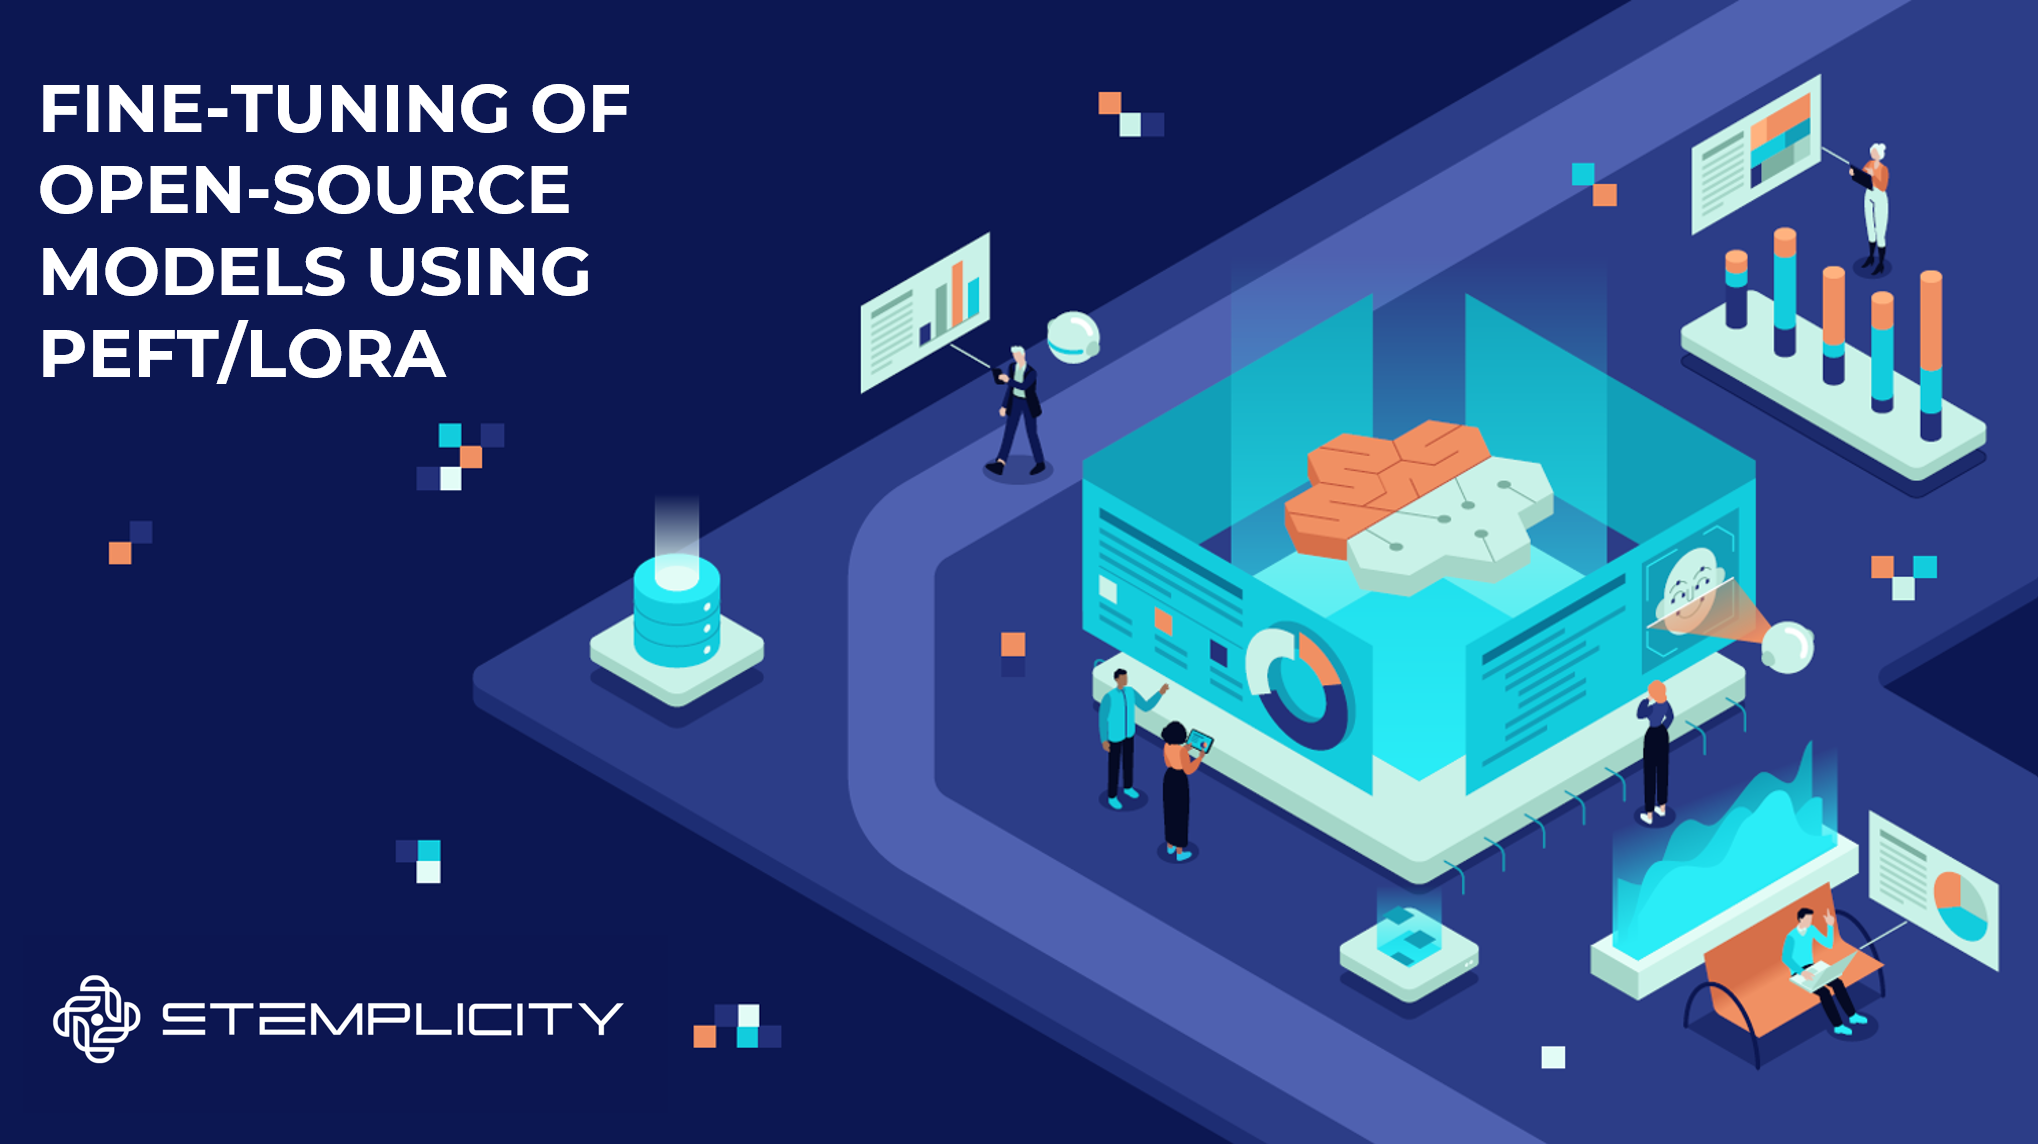

# TASK 1. UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

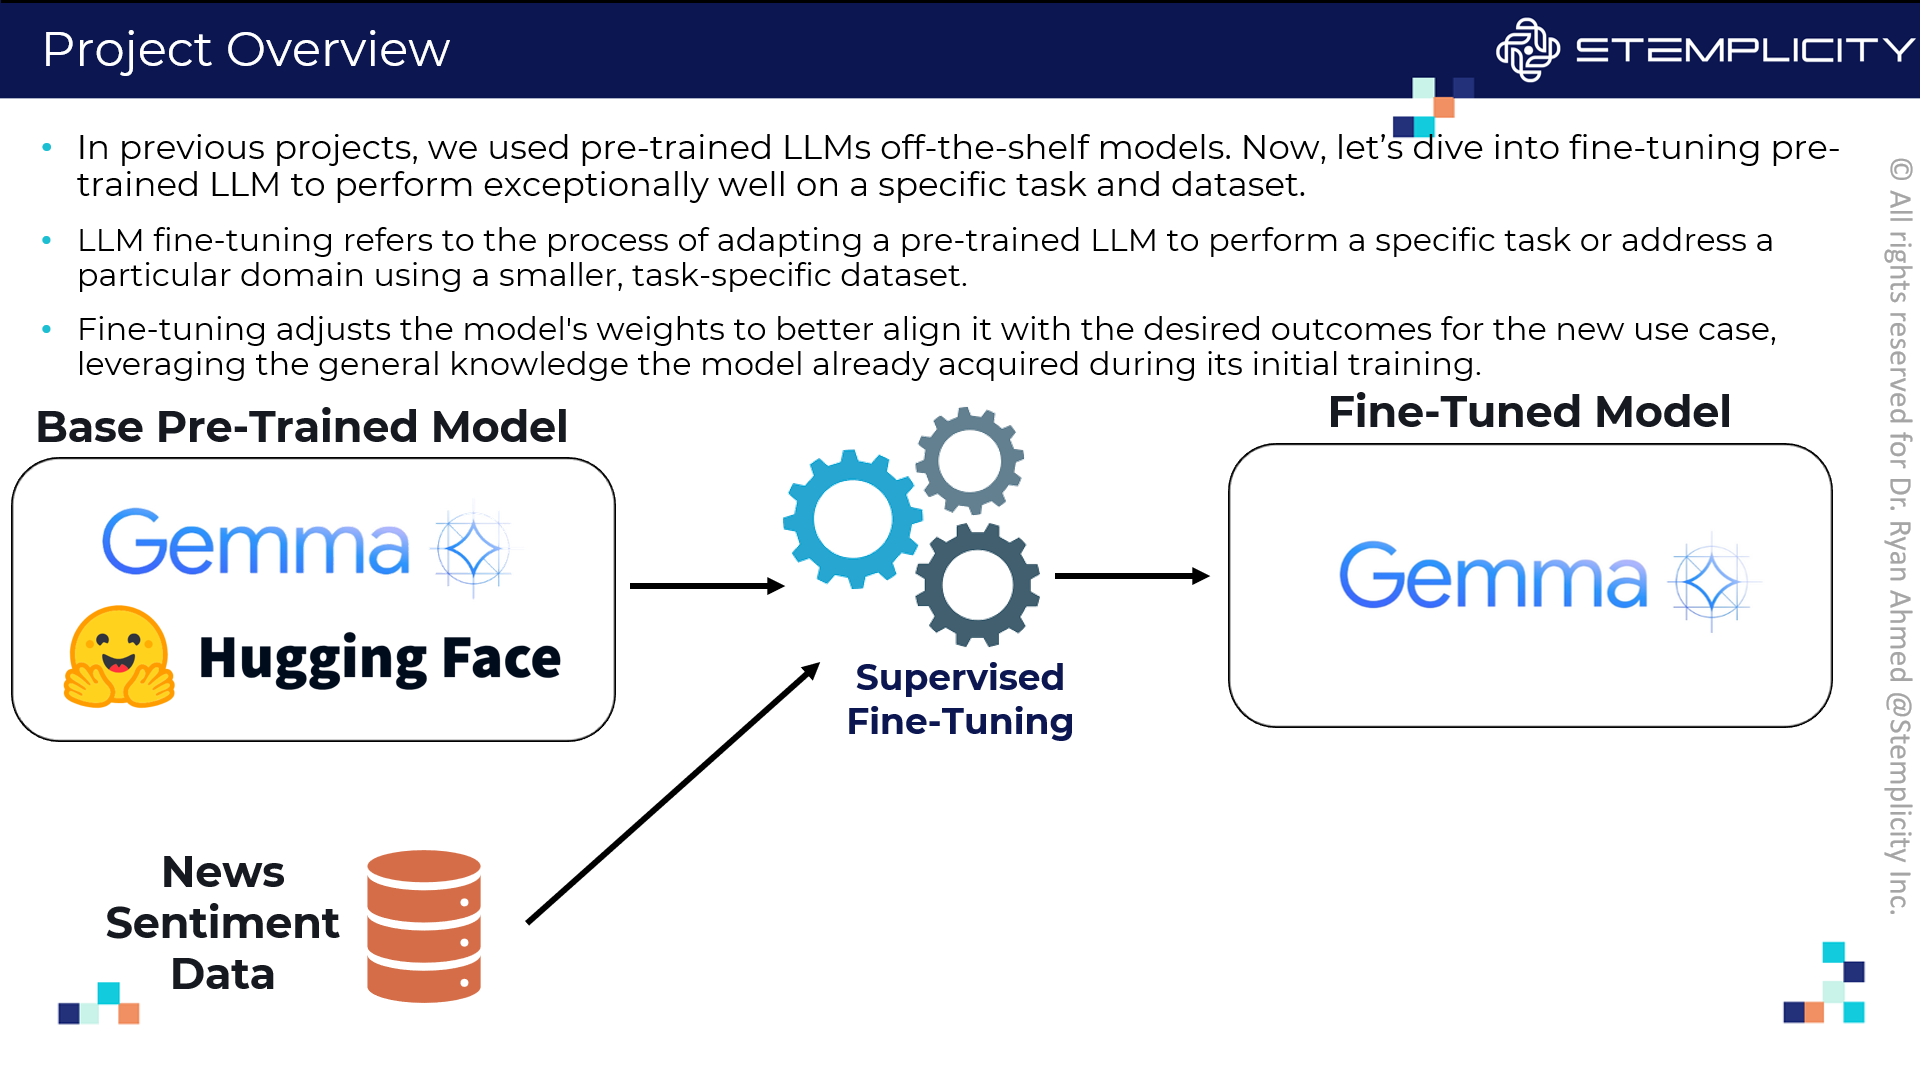

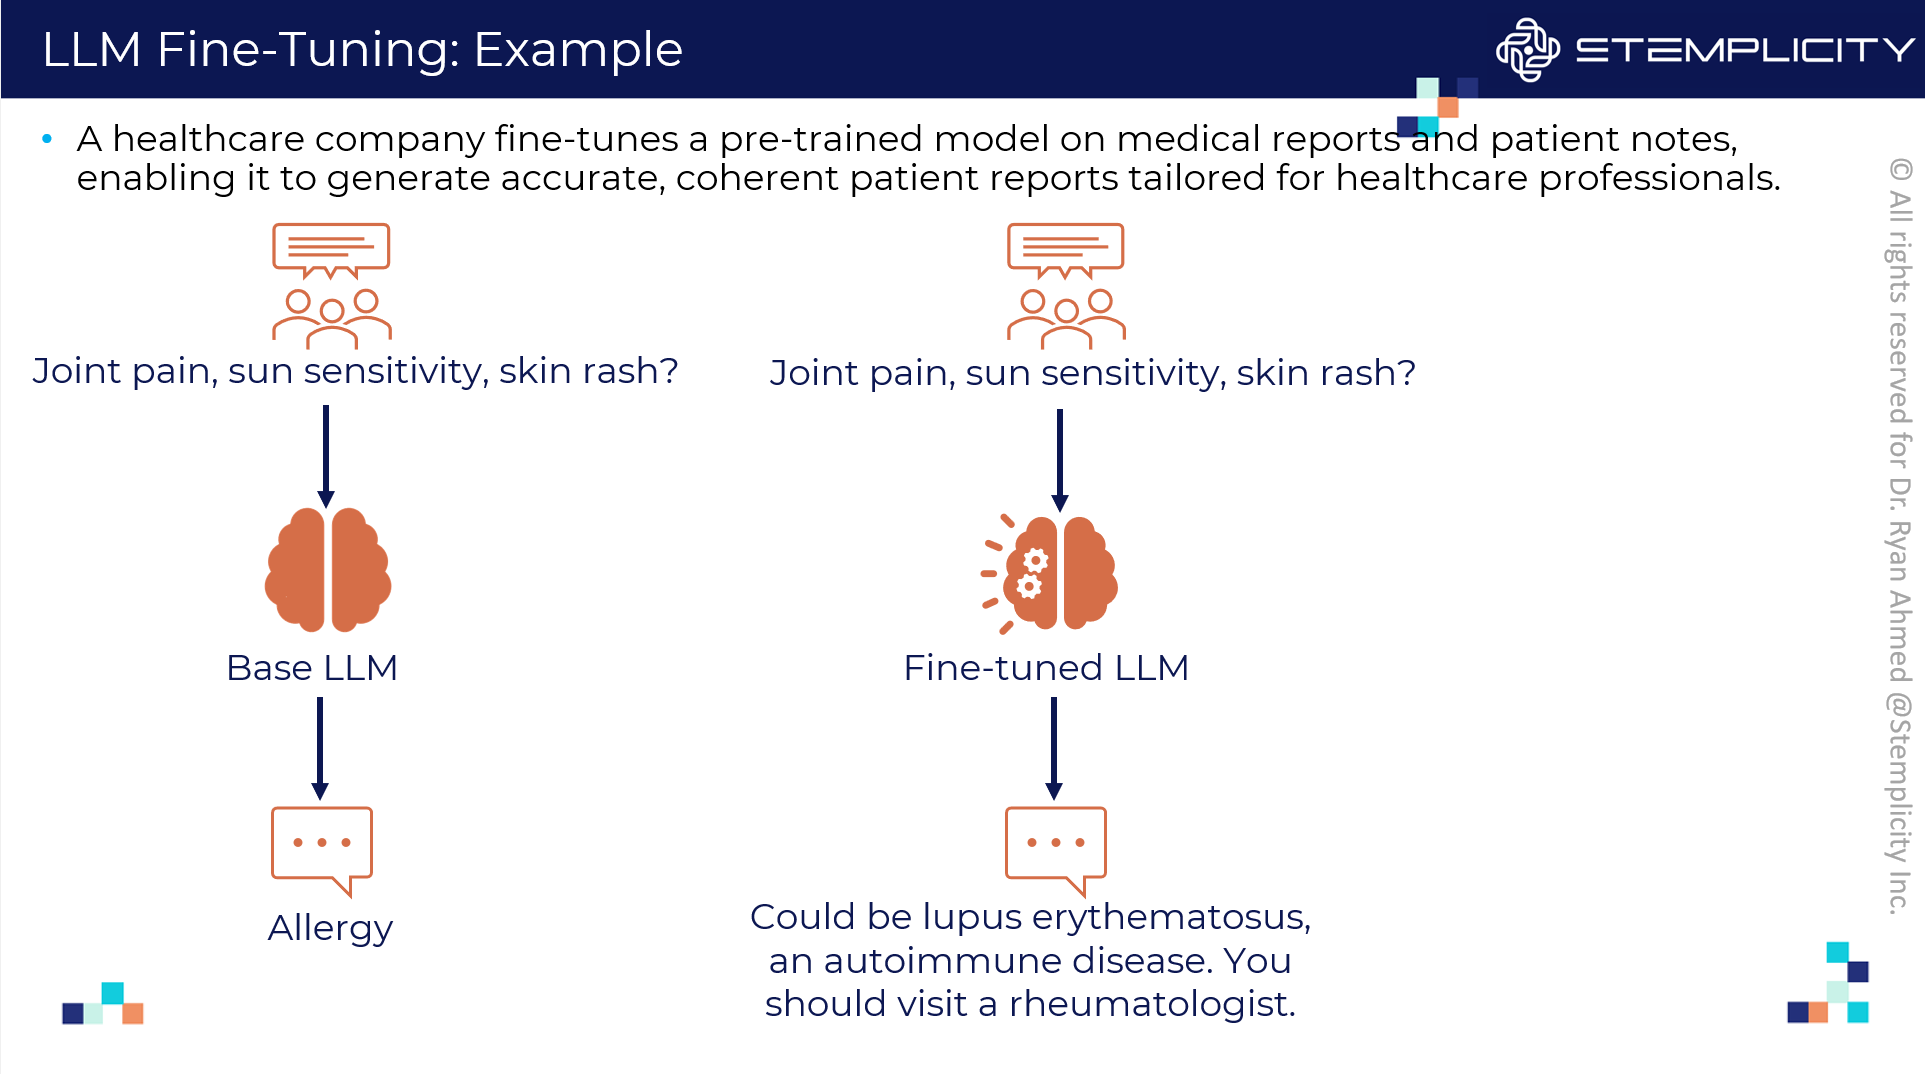

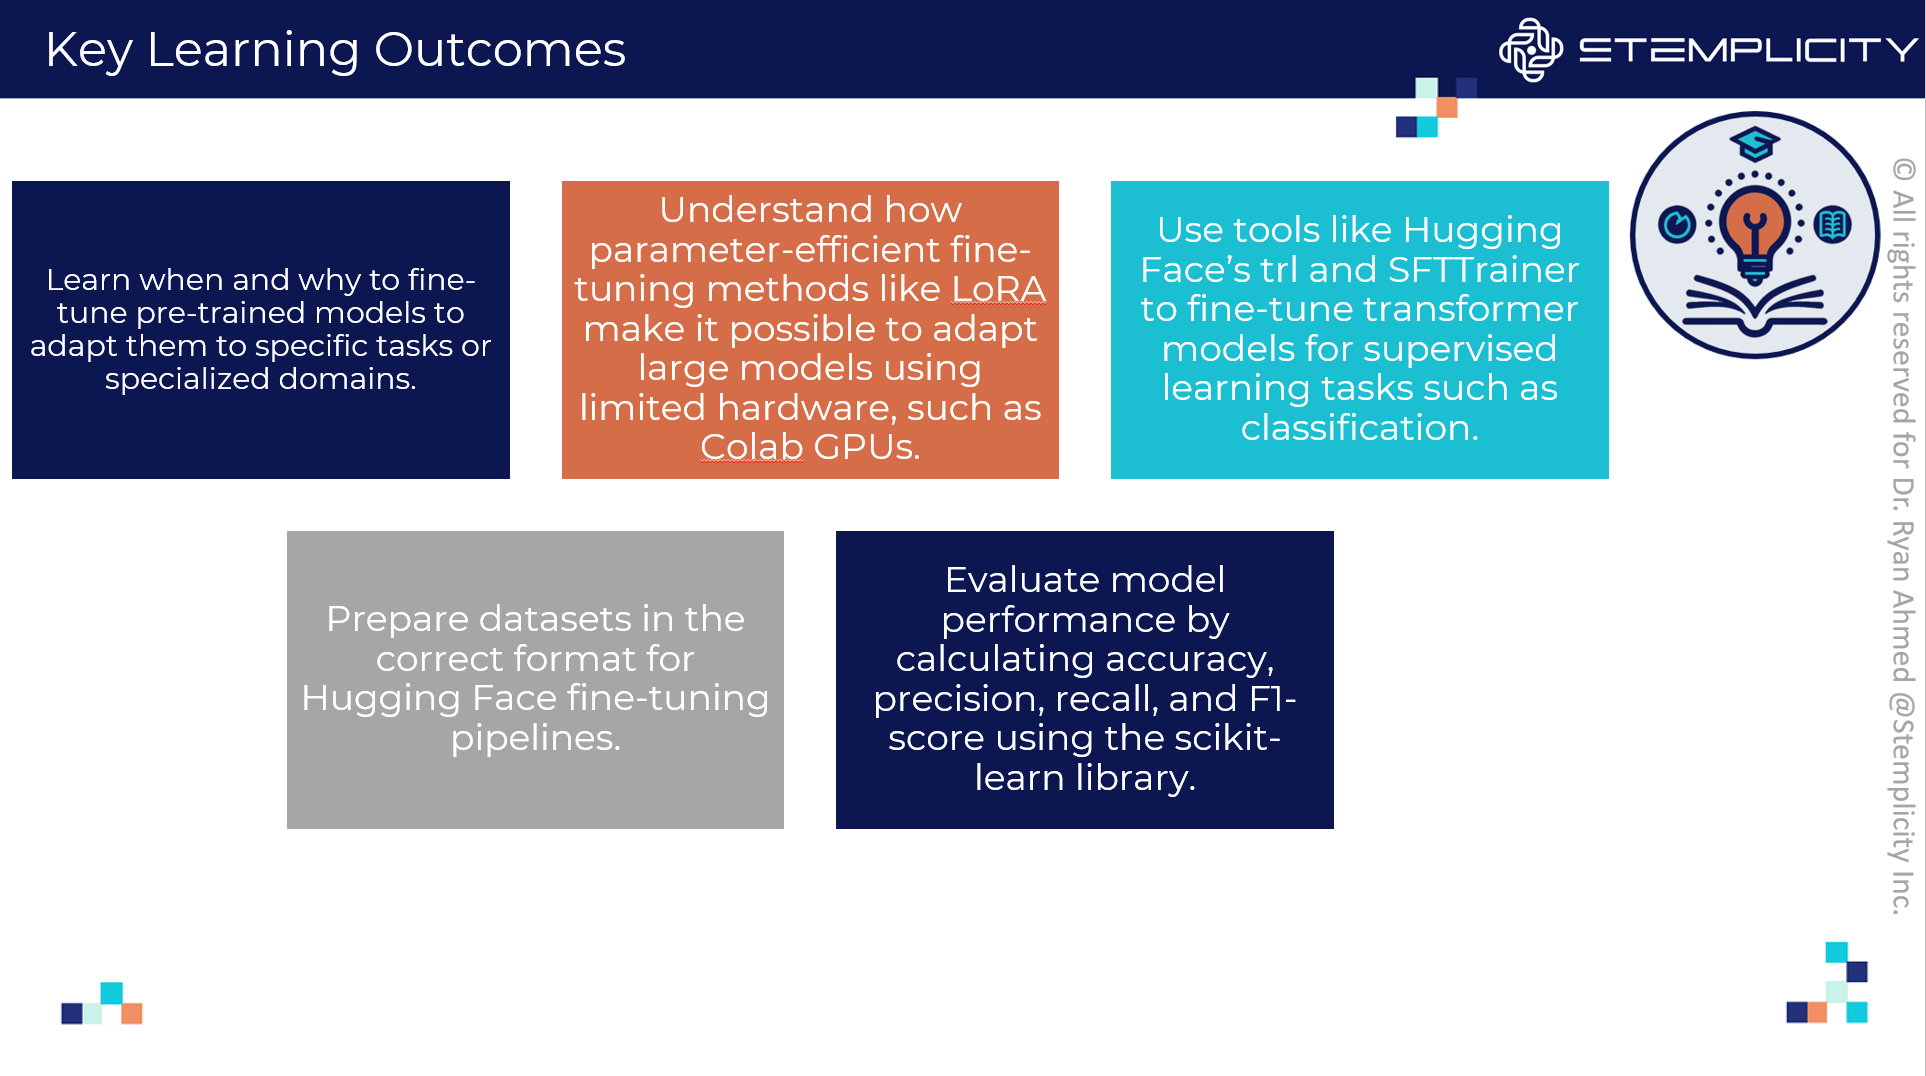

# TASK 2. IMPORT KEY LIBRARIES AND DATASETS


We'll perform financial news sentiment classification using the `Daniel-ML/sentiment-analysis-for-financial-news-v2` dataset, which contains financial news labeled as 'positive', 'negative', or 'neutral'.

**What We'll Build & Compare:**

A system to classify Financial News, comparing two different approaches:
1.  **Zero-Shot Open Source:** Using a pre-trained, small open-source model (like Gemma-1B) without any fine-tuning.
2.  **Fine-Tuned Open Source:** Fine-tuning the same open-source model on this dataset within Colab using efficient techniques (PEFT/LoRA).

**Tech Stack (The Tools We'll Use):**

*   **Python & Google Colab (with GPU):** Our environment.
*   **Hugging Face `transformers`, `datasets`, `accelerate`, `bitsandbytes`:** For OS models and data.
*   **Hugging Face `peft`:** PEFT (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. https://huggingface.co/docs/peft/en/index
*   **Hugging Face `trl`:** TRL (Transformer Reinforcement Learning) is a full stack library where we provide a set of tools to train transformer language models with methods like Supervised Fine-Tuning (SFT). https://huggingface.co/docs/trl/en/index
*   **`scikit-learn`:** For calculating evaluation metrics.
*   **`torch`:** The underlying deep learning framework.

In [ ]:
print("Installing necessary libraries for fine-tuning and evaluation...")

!pip install -q transformers accelerate torch datasets peft trl openai scikit-learn gradio
# !pip install -q transformers accelerate bitsandbytes torch datasets peft trl openai scikit-learn gradio

print("Libraries installed successfully!")

Installing necessary libraries for fine-tuning and evaluation...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 

In [ ]:
import os
from huggingface_hub import login, notebook_login
print("Attempting Hugging Face login...")

notebook_login()
print("HF Login successful (or token already present)!")

Attempting Hugging Face login...


HF Login successful (or token already present)!


In [ ]:
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,  # For quantization config
)
from datasets import load_dataset, Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training  # PEFT tools
from trl import SFTTrainer  # The fine-tuning trainer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import json  # For OpenAI JSONL format
import time  # For waiting on OpenAI jobs
from IPython.display import display, Markdown
import random

print("Core libraries imported.")

# Check for GPU availability (Crucial for fine-tuning)
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Fine-tuning requires a GPU. Please enable GPU in Runtime settings.")
    # Optionally exit or raise an error here


Core libraries imported.
GPU detected: Tesla T4


In [ ]:
# Helper function for markdown display
def print_markdown(text):
    """Displays text as Markdown."""
    display(Markdown(text))

**PRACTICE OPPORTUNITY:**
- **Look at the previous cell output, is a GPU detected?**
- **Why is confirming GPU presence absolutely critical for this project compared to previous ones?**

# TASK 3: LOAD AND PREPARE THE FINANCIAL NEWS DATASETS


We'll load the `Daniel-ML/sentiment-analysis-for-financial-news-v2` dataset from the Hugging Face Hub. This dataset contains sentences from Financial News, with sentiments tagged.

**Steps:**
1.  Load the dataset using `load_dataset`.
2.  Inspect its structure and labels.
3.  Split the data into training and testing sets to evaluate our models fairly.


In [ ]:
# Link to the dataset on Hugging Face: https://huggingface.co/datasets/Daniel-ML/sentiment-analysis-for-financial-news-v2/viewer
dataset_id = "Daniel-ML/sentiment-analysis-for-financial-news-v2"

print(f"Loading dataset: {dataset_id}...")
labeled_dataset = load_dataset(dataset_id, split = "train")  # Load the main split
print("Dataset loaded successfully!")

# Let's view the dataset
print("\n--- Dataset Information ---")
print(labeled_dataset)


Loading dataset: Daniel-ML/sentiment-analysis-for-financial-news-v2...


README.md:   0%|          | 0.00/36.0 [00:00<?, ?B/s]

pd_df_json.json:   0%|          | 0.00/788k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset loaded successfully!

--- Dataset Information ---
Dataset({
    features: ['sentiment', 'text'],
    num_rows: 4846
})


In [ ]:
# Let's view the dataset features
print("\n--- Dataset Features ---")
print(labeled_dataset.features)


--- Dataset Features ---
{'sentiment': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}


In [ ]:
# Let's explore how many unique lables exist in the dataset

labels = labeled_dataset.to_pandas()['sentiment'].unique().tolist()
print(f"Unique labels in the dataset: {labels}")


Unique labels in the dataset: ['neutral', 'negative', 'positive']


In [ ]:
# Let's view the data as a Pandas DataFrame
display(labeled_dataset.select(range(5)).to_pandas()[["text", "sentiment"]])

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [ ]:
# Let's Split the Data into Train and Test Sets ---
print("\nSplitting data into Train (90%) and Test (10%)...")
train_test_split_ratio = 0.10
seed = 42  # for reproducibility

# Using datasets built-in method
split_dataset = labeled_dataset.train_test_split(
    test_size = train_test_split_ratio, seed = seed, shuffle = True,
)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print("\nTrain/Test Split Complete.")


Splitting data into Train (90%) and Test (10%)...
Training set size: 4361
Test set size: 485

Train/Test Split Complete.


**PRACTICE OPPORTUNITY:**
- **Use Seaborn library to count how many samples belong to 'positive', 'negative', 'neutral' classes. Do we have a balanced datasets? How might class imbalance affect model training and evaluation?**

# TASK 4: FORMAT THE DATA INTO SUPERVISED FINE TUNING (SFT) TRAINER FORMAT

In [ ]:
# Let's define a function that performs chat messages formatting
# We will use "apply_chat_template()" which wraps the messages in a format the model understands
# Just like giving it a movie script so it knows who’s speaking and when to reply.
# It takes a list of messages (like a chat between a user and an assistant) and turns it into one long, properly formatted text, exactly how the model expects to read it.

def format_for_sft_gemma(example, tokenizer):

    # Define the conversation structure
    system_prompt = "Classify the sentiment of the following sentence from News as positive, negative, or neutral."
    user_prompt = f"Sentence: {example['text']}"
    assistant_response = example['sentiment'] # The target label

    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"}, # Combine system/user for simplicity here
        {"role": "assistant", "content": assistant_response}
    ]
    # Apply the tokenizer's chat template.
    # tokenize = False: means we want the text output, not token IDs.
    # add_generation_prompt = False: means we’re NOT adding the assistant prompt to generate the response. We already provided the assistant's message
    formatted_text = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt = False)
    return {"text": formatted_text}

print("\nSupervised Fine Tuning (SFT) Trainer formatting function defined")



Supervised Fine Tuning (SFT) Trainer formatting function defined


In [ ]:
# Let's test out the function!
# This code is setting up a Gemma language model (specifically google/gemma-3-1b-it) with 4-bit quantization using BitsAndBytesConfig
# for efficient loading which is useful on limited hardware like a laptop or free Colab GPU.

from tqdm.notebook import tqdm  # Progress bar meaning takadom "progress" in Arabic

# Let's choose the Gemma 3.1B Instruct model by Google
# It's a small instruction-tuned LLM that's good for chat, Q&A, etc.
os_model_id = "google/gemma-3-1b-it"

# Let's define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # Use 4-bit weights (saves lots of RAM)
    bnb_4bit_quant_type = "nf4", # nf4 is a better 4-bit format (Non-Float 4)
    bnb_4bit_compute_dtype = torch.float16 # Math is done in float16 for speed
)

# Let's load the Tokenizer associated with the model. Tokenizers convert text to tokens (numbers).
# It’s like the model’s language interpreter.
base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Set pad token if missing (Gemma often doesn't have one)
# A pad token is a special token used to make all input sequences the same length in a batch.
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")


In [ ]:
# Sample input dictionary
# <bos>                      → Beginning of sequence (tells the model: "Start reading")
# <start_of_turn>user        → Start of the user's turn
# Classify the sentiment...  → Instruction and user input
# <end_of_turn>              → End of user input
# <start_of_turn>model       → Start of the assistant/model's reply
# positive                   → The expected response
# <end_of_turn>              → End of assistant reply

example = {
    "text": "The economy is showing signs of recovery after a tough year.",
    "sentiment": "positive"
}

# Apply your formatting function
formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

# Print the result
print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])


--- Sample Formatted Prompt ---
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: The economy is showing signs of recovery after a tough year.<end_of_turn>
<start_of_turn>model
positive<end_of_turn>



**PRACTICE OPPORTUNITY:**
- **Try a different random sample from the data and perform a sanity check.**
- **Change the model to deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and observe the formatted output. Explore the special tokens used and compare it to the Gemma Model.**

# TASK 5: CONFUSION MATRIX & CLASSIFICATION MODELS METRICS (PRECISION, RECALL, & F1-SCORE)

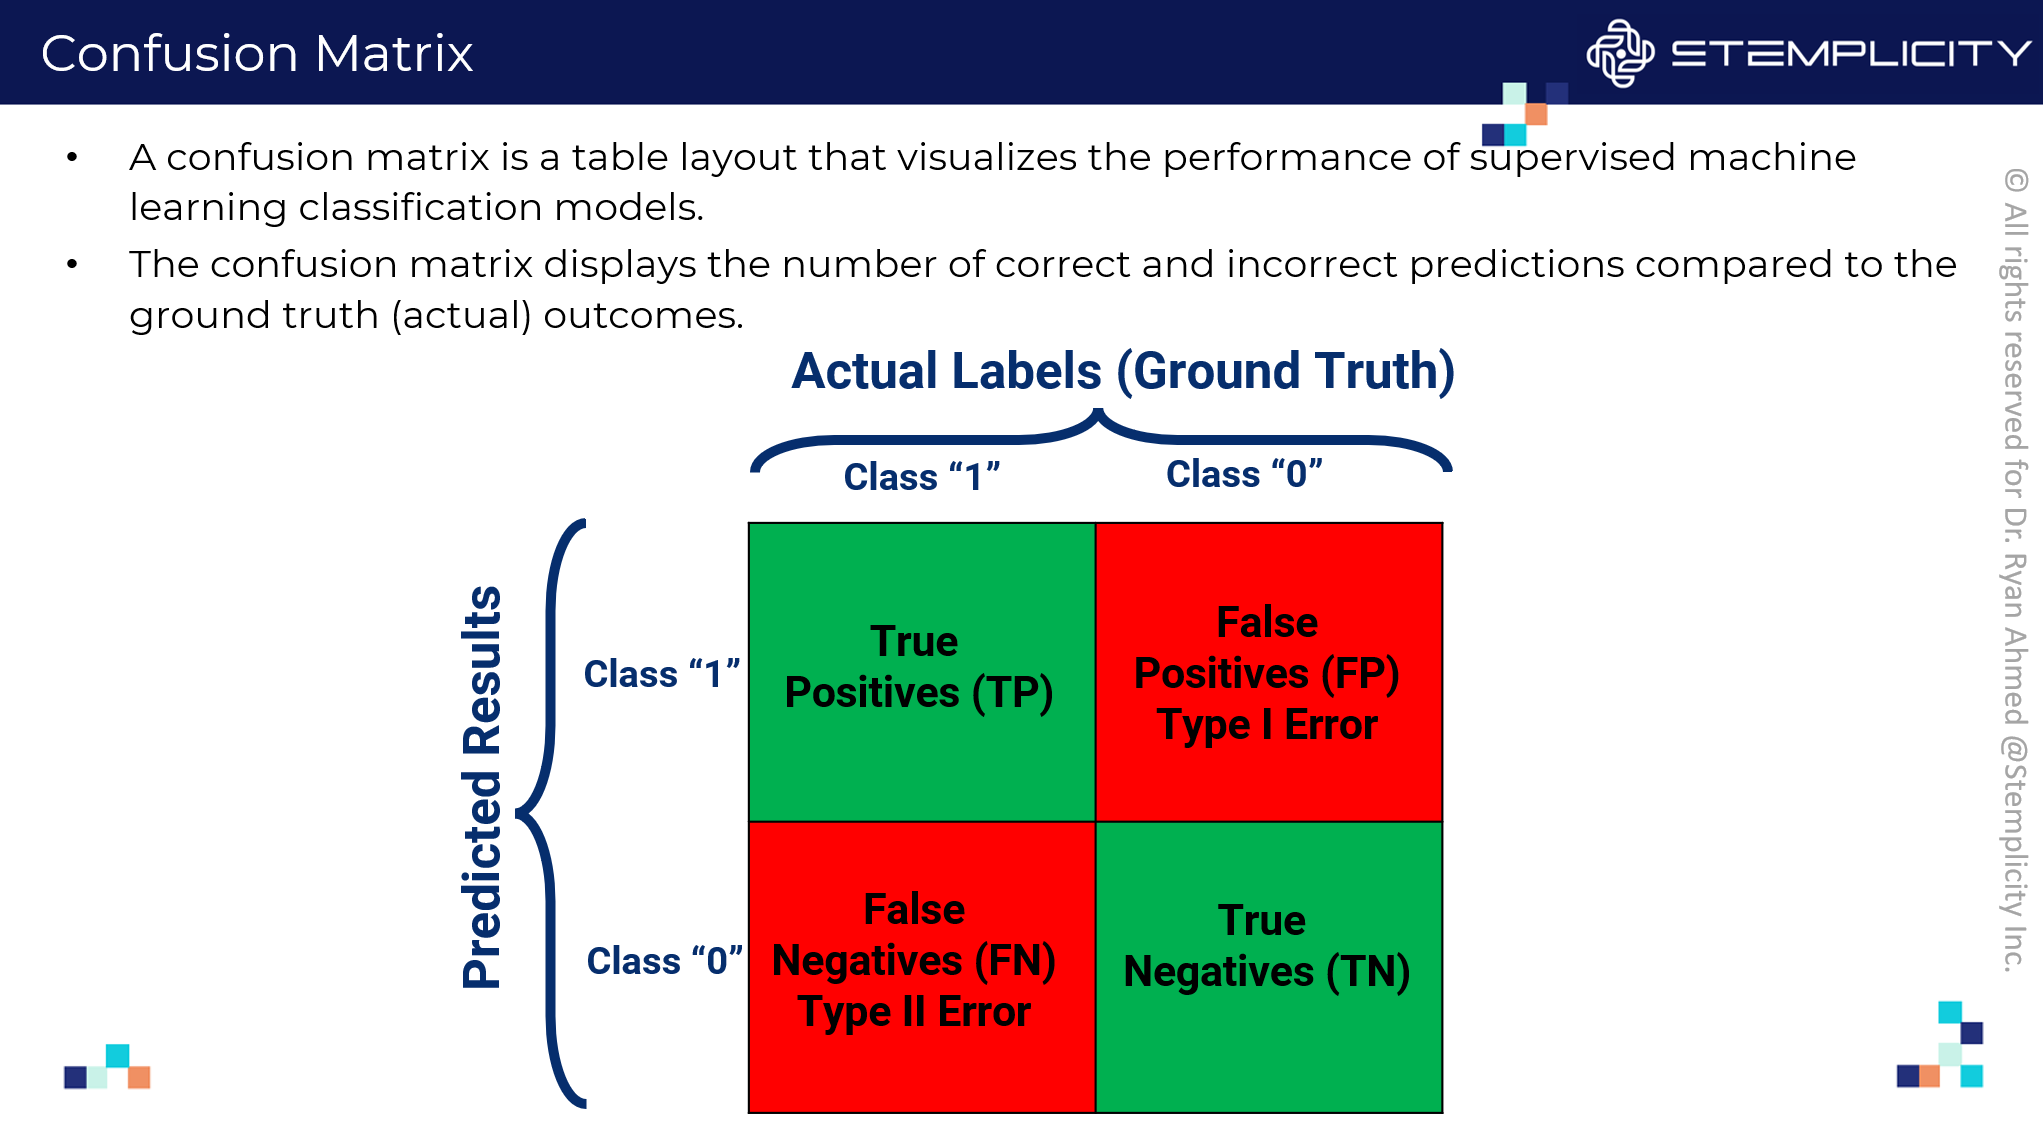

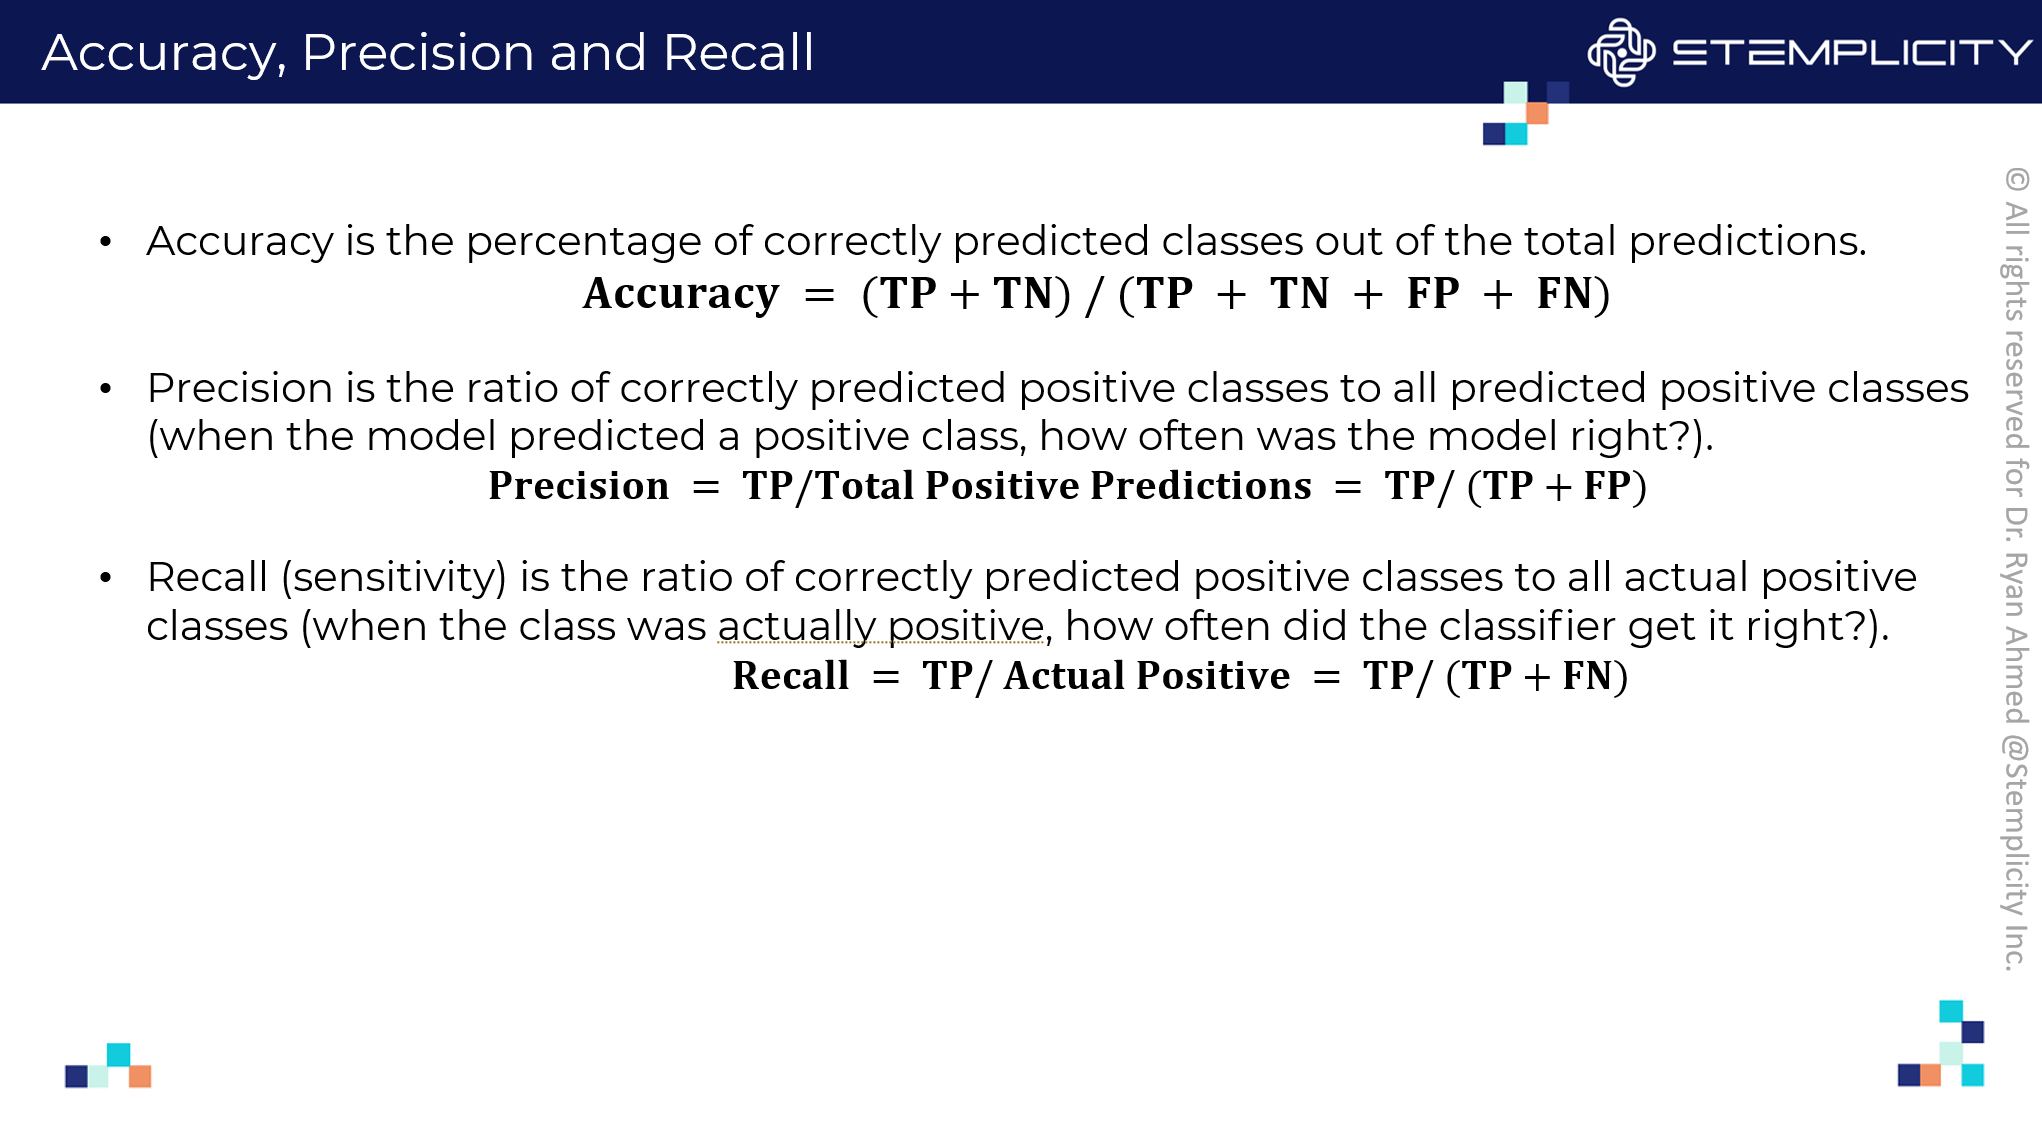

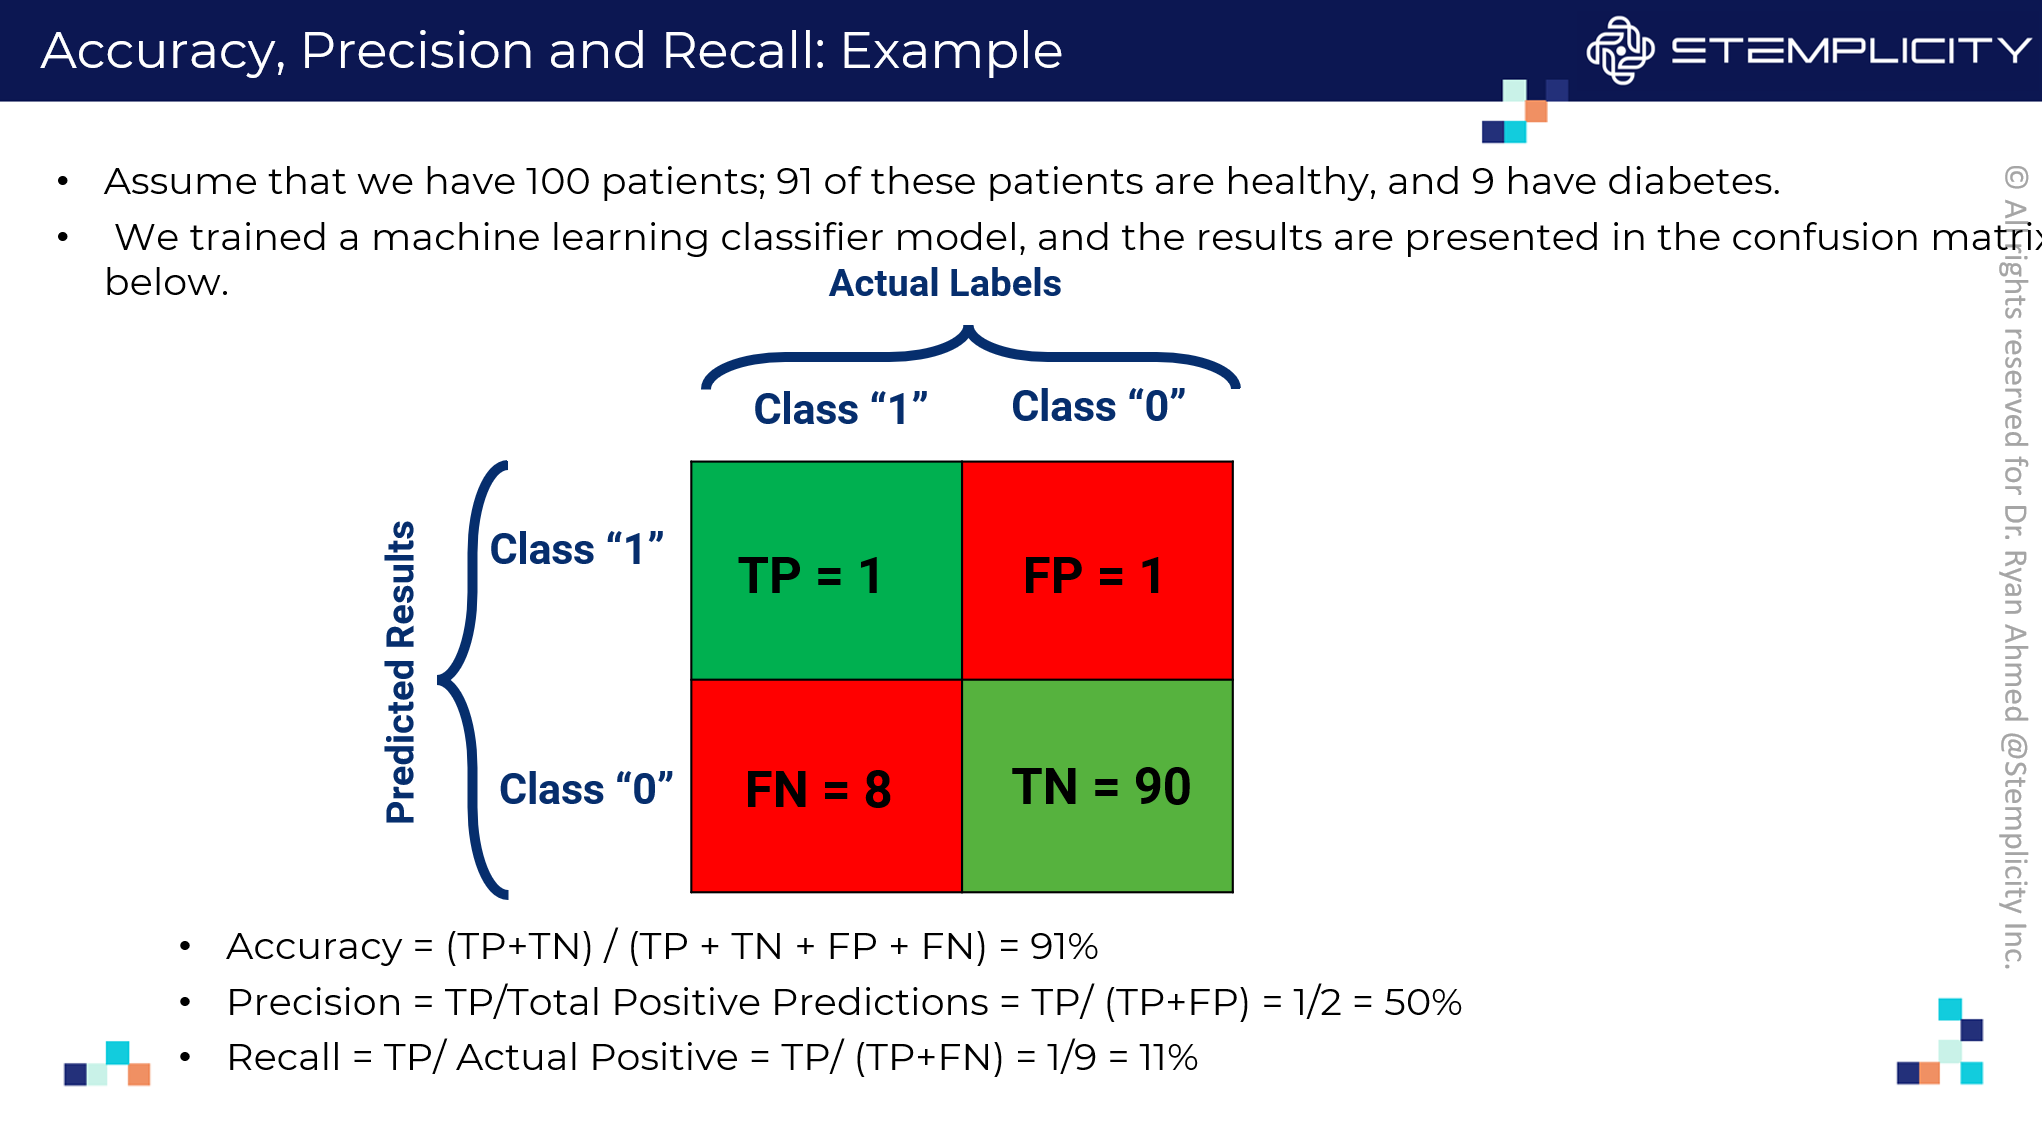

## TASK 6: PERFORM ZERO-SHOT CLASSIFICATION WITH THE BASE MODEL (INFERENCE ONLY)


Before fine-tuning, let's see how a pre-trained open-source model performs on this task without any specific training data. This gives us a baseline.

We'll use the `google/gemma-3-1b-it` model again loaded with 4-bit quantization.

**Steps:**
1.  Load the quantized base model and tokenizer.
2.  Define a prompt template specifically for zero-shot classification (asking the model to output only the label).
3.  Create a function to run inference on the test set. This function needs to handle potential model outputs that aren't exactly one of the expected labels.
4.  Calculate and display evaluation metrics (Accuracy, Classification Report).




In [ ]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,  # For quantization config
)
import torch
import transformers

In [ ]:
from tqdm.notebook import tqdm  # Progress bar

# Choose Model
os_model_id = "google/gemma-3-1b-it" # <-- UPDATED Model ID


# Load Base Model (Quantized)
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4", # Recommended type
    bnb_4bit_compute_dtype = torch.float16
)

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Set pad token if missing (Gemma often doesn't have one)
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")

# Load model
base_os_model = AutoModelForCausalLM.from_pretrained(
    os_model_id,
    quantization_config = quantization_config,
    torch_dtype = torch.float16,
    device_map = "auto",
)
# Ensure model pad token ID is updated if tokenizer's was
base_os_model.config.pad_token_id = base_os_tokenizer.pad_token_id
print("Base Gemma model and tokenizer loaded successfully.")



Base Gemma model and tokenizer loaded successfully.


In [ ]:
# Let's apply the SFT formatting function to our training and testing datasets
print("\nFormatting data for SFTTrainer (Gemma format)...")
sft_train_dataset = train_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(train_dataset.features)
              )
sft_test_dataset = test_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(test_dataset.features)
              )
print("SFTTrainer (Gemma) formatting complete.")
print("Sample SFT Gemma format:")
print(sft_train_dataset[0]['text'])


Formatting data for SFTTrainer (Gemma format)...
SFTTrainer (Gemma) formatting complete.
Sample SFT Gemma format:
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: These module products will be available for trials during 3Q-07 and for volume deliveries during 4Q-07 .<end_of_turn>
<start_of_turn>model
neutral<end_of_turn>



In [ ]:
# Perform Zero-Shot Classification Prompt Function (Gemma)
def create_zeroshot_prompt_gemma(sentence, tokenizer):

    """Creates zero-shot prompt using Gemma chat template."""
    system_prompt = f"Classify the sentiment of the following sentence from Financial News. Respond with ONLY ONE of the following labels: {', '.join(labels)}."
    user_prompt = f"Sentence: {sentence}"
    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"},
    ]
    # Apply template, add_generation_prompt=True adds the assistant turn marker
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


In [ ]:
# Inference Function for Zero-Shot (Gemma)
# This function runs inference using the prompt generated above and returns the predicted sentiment label.
# It Gets the formatted prompt using the first function "create_zeroshot_prompt_gemma".
# It then tokenizes the prompt and sends it to the appropriate device (e.g., GPU):
def classify_zero_shot_os_gemma(sentence, model, tokenizer):

    prompt = create_zeroshot_prompt_gemma(sentence, tokenizer)
    inputs = tokenizer(prompt, return_tensors = "pt", truncation = True, max_length = 512).to(model.device)

    eos_id = tokenizer.eos_token_id          # eos_token_id: end of sentence
    pad_id = tokenizer.pad_token_id          # pad_token_id: padding token

    # Run the model to generate output, we are not performing gradient tracking since it's only inference!
    with torch.no_grad():

      outputs = model.generate(
          **inputs,
          max_new_tokens = 10, # Limits the number of tokens the model can generate
          eos_token_id = eos_id,
          pad_token_id = eos_id,
          do_sample = False
      )
    # Extracts and decode the generated text
    response_ids = outputs[0][inputs['input_ids'].shape[1]:]
    response_text = tokenizer.decode(response_ids, skip_special_tokens=True).strip()

    # print(f"Generated Text (Gemma): {response_text}")

    # Clean and Validate Output
    labels = ["neutral", "negative", "positive"]

    predicted_label = "Unknown"
    for label_text in labels:
        if label_text.lower() in response_text.lower(): # Simple check if label is present
              predicted_label = label_text
              break

    print(f"Predicted Label: {predicted_label}")
    return predicted_label


In [ ]:
true_labels = []

# Let's extract the ground truth (target output) which represents the True class
true_labels = [ex['sentiment'] for ex in test_dataset]
true_labels

['neutral',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 '

In [ ]:
# --- Evaluate on Test Set ---
base_os_predictions = [] # Renaming for clarity if needed, but reusing is fine

# Let's perform inference on all testing datasets using the pre-trained Gemma LLM
for example in tqdm(test_dataset):
    predicted_label = classify_zero_shot_os_gemma(example['text'], base_os_model, base_os_tokenizer)
    base_os_predictions.append(predicted_label)


  0%|          | 0/485 [00:00<?, ?it/s]

Predicted Label: positive
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label

In [ ]:
print("\n--- Base Gemma Model: Zero-Shot Evaluation Results ---")
valid_indices = [i for i, p in enumerate(base_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds = [base_os_predictions[i] for i in valid_indices]
filtered_true = [true_labels[i] for i in valid_indices]

accuracy = accuracy_score(filtered_true, filtered_preds)
report = classification_report(filtered_true, filtered_preds, labels=labels, zero_division=0, target_names=labels)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
# (Optional: show sample predictions)


--- Base Gemma Model: Zero-Shot Evaluation Results ---
Accuracy: 0.4598

Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.16      0.27       290
    negative       0.56      0.84      0.67        56
    positive       0.37      0.94      0.53       139

    accuracy                           0.46       485
   macro avg       0.61      0.64      0.49       485
weighted avg       0.71      0.46      0.39       485



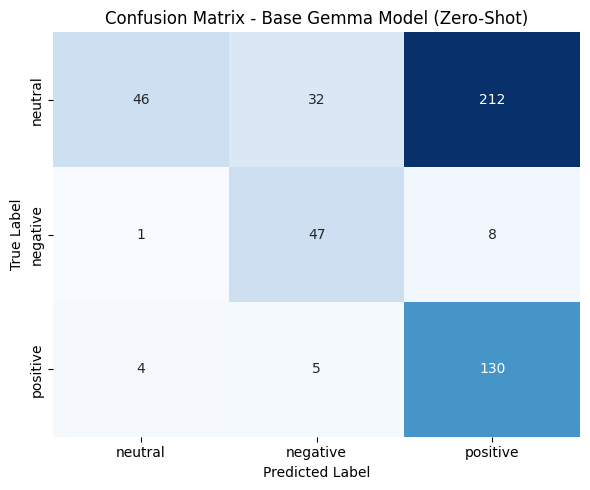

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(filtered_true, filtered_preds, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Base Gemma Model (Zero-Shot)")
plt.tight_layout()
plt.show()

**PRACTICE OPPORTUNITY:**
- **Modify the `system_prompt` inside `create_zeroshot_prompt`. Try making it simpler. For example, remove the list of labels and just say "Classify the sentiment". Re-run the evaluation for a few iterations. Does the performance change significantly? Why might small models be sensitive to prompt wording for zero-shot classification?**


# TASK 7. FINE-TUNING OPEN SOURCE MODEL (PEFT/LORA & SFTTRAINER)

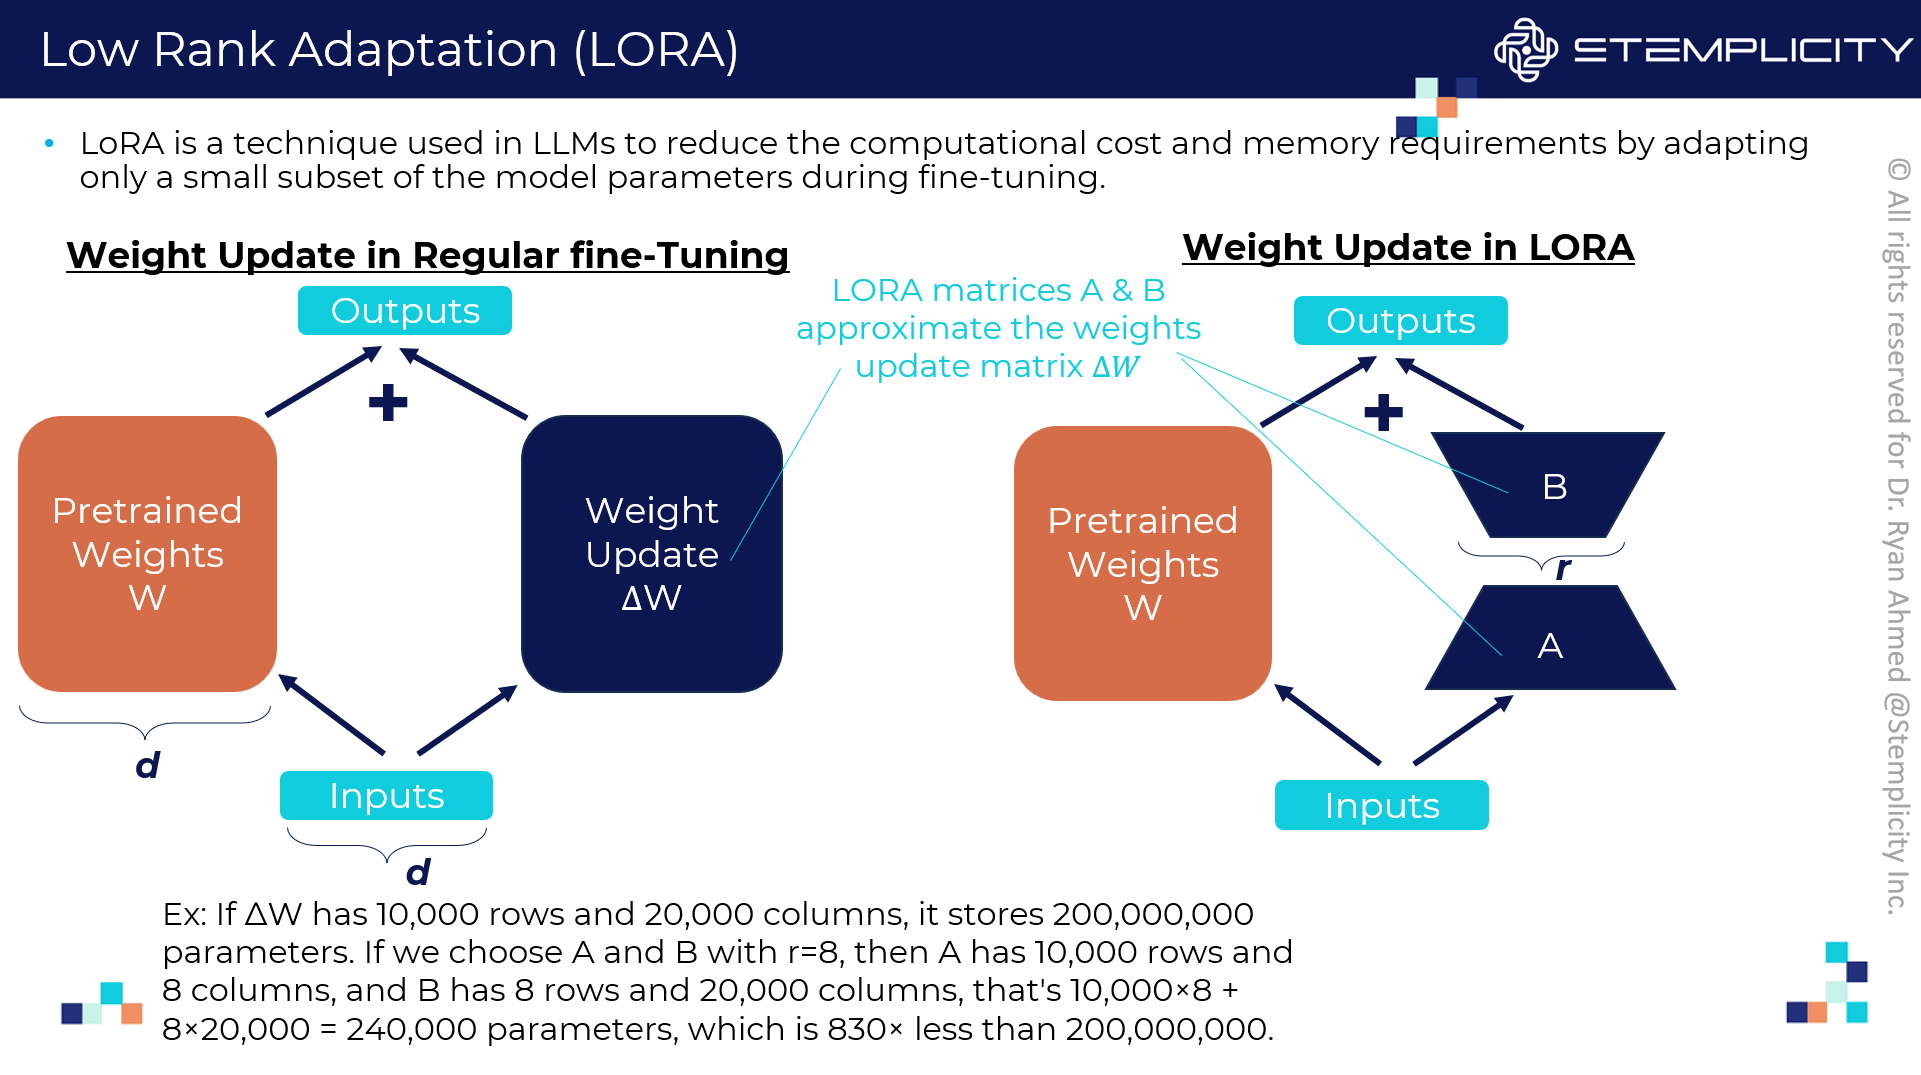

- LORA Paper: https://arxiv.org/abs/2106.09685

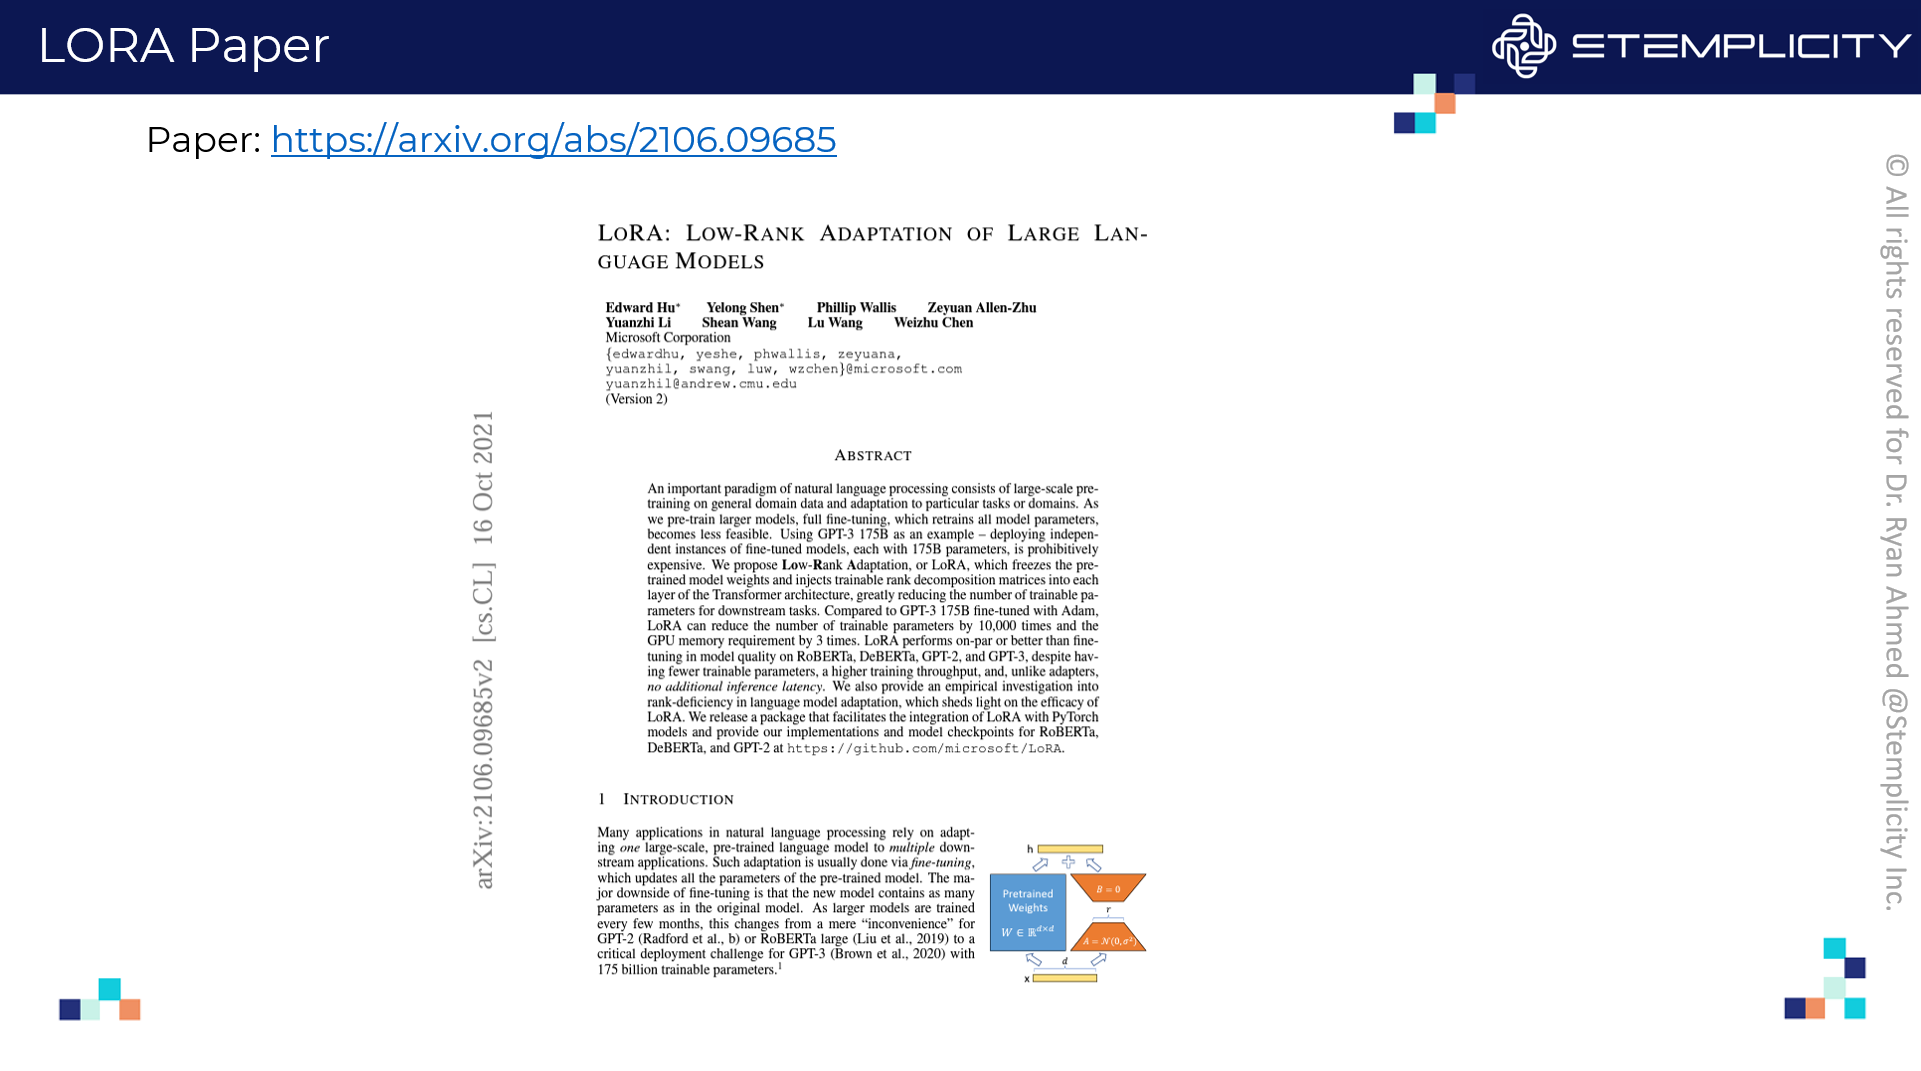

Now for the exciting part! We'll fine-tune our base open-source model using the training data we prepared. We'll use **PEFT (LoRA)** to do this efficiently without needing massive amounts of VRAM. `SFTTrainer` from the `trl` library simplifies the training loop.

**Key Concepts:**
*   **PEFT (Parameter-Efficient Fine-Tuning):** Instead of updating all the billions of parameters in the LLM, PEFT methods like LoRA add small, trainable "adapter" layers. We only train these adapters, which is much faster and uses far less memory.
*   **LoRA (Low-Rank Adaptation):** A popular PEFT technique that injects trainable low-rank matrices into the model's layers.
*   **`SFTTrainer`:** A convenient Hugging Face trainer class designed for Supervised Fine-tuning tasks where the input is formatted text (like our prompts) and the model learns to generate the desired output (the label).

**Steps:**
1.  **Load Base Model (again, if needed):** Ensure the base model and tokenizer are loaded, this time prepared for training (using `prepare_model_for_kbit_training`).
2.  **Configure LoRA:** Define `LoraConfig` specifying which parts of the model to adapt and the LoRA parameters (like rank `r`, `alpha`).
3.  **Configure Training Arguments:** Set hyperparameters like learning rate, batch size, number of epochs, output directory using `TrainingArguments`.
4.  **Initialize `SFTTrainer`:** Pass the model, tokenizer, datasets, LoRA config, and training arguments.
5.  **Start Training:** Call `trainer.train()`.
6.  **Save Adapter:** Save the trained LoRA adapter weights using `trainer.save_model()`.
7.  **Load Fine-tuned Model:** Load the base model *plus* the trained LoRA adapter weights for evaluation.


In [ ]:
# A Quick reminder to our formatted training dataset in an SFT-Trainer format.
# The `SFTTrainer` works by training the model on a Causal Language Modeling objective.
# This means the model learns to predict the next token in a sequence.
# By providing the entire formatted text (including the `assistant`'s response, i.e., the correct label),
# the model learns that after seeing the system prompt and the user sentence,
# the most likely next token sequence is the correct label (e.g., "negative" followed by `<|im_end|>`).
# It learns the mapping from input (prompt + sentence) to output (label) implicitly through next-token prediction on this structured text.


print("\n--- Preparing Model and Config for PEFT/LoRA Fine-tuning ---")

# --- Prepare model for k-bit training (important for quantized models) ---
base_os_model.gradient_checkpointing_enable()  # Saves memory during training
prepared_model = prepare_model_for_kbit_training(base_os_model)
print("Model prepared for k-bit training.")

print(prepared_model)


# --- LoRA Configuration ---
# Target modules often include query/key/value layers in attention blocks
# This depends on the model architecture (use print(prepared_model) to inspect layers)
# For Qwen-based models, common targets might be 'q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'
# Let's start with a reasonable default set
lora_config = LoraConfig(
    r = 16,  # LoRA rank (dimension of adapter matrices). Higher rank = more parameters, potentially better fit but slower. 8, 16, 32 are common.
    lora_alpha = 32,  # Scaling factor for LoRA weights (often 2*r).
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],  # Modules to apply LoRA to.
    lora_dropout = 0.05,  # Dropout probability for LoRA layers.
    bias = "none",  # Usually set to 'none'.
    task_type = "CAUSAL_LM",  # Task type for sequence generation.
)
print("LoRA Config created.")

# --- Apply PEFT to the model ---
# This adds the small LoRA layers into the big model. During fine-tuning, only these are updated — saving a lot of compute and memory
peft_model = get_peft_model(prepared_model, lora_config)



# The percentage (often < 1%) is small because LoRA only introduces and trains the parameters within the small adapter layers (`q_proj`, `k_proj`, etc. in our config),
# It does not train the original billions of parameters in the base model (which remain frozen).
# Training far fewer parameters requires significantly less GPU memory (VRAM), making it feasible to fine-tune large models on hardware like Colab's T4 GPU.
# It's also much faster than full fine-tuning.
print("PEFT model created.")
peft_model.print_trainable_parameters()  # See how few parameters we're actually training!



--- Preparing Model and Config for PEFT/LoRA Fine-tuning ---
Model prepared for k-bit training.
Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=1152, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1152, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=1024, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Line

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
# --- Training Arguments ---
# These hyperparameters control the training process. Adjust based on performance and time constraints.
output_dir = "./sentiment_finetuned_adapter"  # Directory to save adapter weights

training_args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size = 4,  # Adjust based on GPU memory (2, 4, 8 typical for Colab)
    gradient_accumulation_steps = 2,  # Effective batch size = batch_size * grad_accum_steps
    learning_rate = 2e-4,  # Common starting point for LoRA
    num_train_epochs = 1,  # Start with 1 epoch for faster iteration/testing. Increase to 2-3 if needed.
    logging_steps = 25,  # Log training loss every N steps
    save_strategy = "epoch",  # Save adapter checkpoint at the end of each epoch
    # optim="paged_adamw_8bit", # Use paged optimizer for memory efficiency (requires bitsandbytes >= 0.41.0) - try if memory issues occur
    fp16=not torch.cuda.is_bf16_supported(),  # Use fp16 if bf16 not supported
    bf16 = torch.cuda.is_bf16_supported(),  # Use bf16 if supported (preferred)
    max_grad_norm = 0.3,  # Gradient clipping
    warmup_ratio = 0.03,  # Learning rate warmup
    lr_scheduler_type = "constant",  # Or "linear", "cosine"
    report_to = "none",  # Disable wandb/tensorboard reporting for simplicity
)
print("Training Arguments set.")

# --- Initialize SFTTrainer ---
trainer = SFTTrainer(
    model = peft_model,  # The PEFT model
    args = training_args,  # Training arguments
    train_dataset = sft_train_dataset,  # Formatted training data
    peft_config = lora_config,  # Pass the LoRA config again
)
print("SFTTrainer initialized.")

# --- Start Fine-tuning ---
print("\n--- Starting Fine-tuning... ---")
try:
    training_results = trainer.train()
    print("--- Fine-tuning Complete! ---")
    print(training_results)

    # --- Save the LoRA Adapter ---
    print(f"Saving LoRA adapter model to {output_dir}...")
    trainer.save_model(output_dir)  # Saves only the adapter weights
    # Also save the tokenizer for consistency
    base_os_tokenizer.save_pretrained(output_dir)
    print("Adapter and tokenizer saved.")

    # --- Clean up memory (important before loading for evaluation) ---
    del trainer
    del peft_model  # Delete the model used for training
    # del prepared_model # Optional
    # del base_os_model # Keep the original base model if needed later, or delete
    torch.cuda.empty_cache()
    import gc

    gc.collect()
    print("Cleaned up training objects from memory.")

    fine_tuning_successful = True

except Exception as e:
    print(f"Error during fine-tuning: {e}")
    fine_tuning_successful = False



Training Arguments set.


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


SFTTrainer initialized.

--- Starting Fine-tuning... ---


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,3.534900
50,2.005200
75,1.737200
100,1.608500
125,1.617800
150,1.554100
175,1.537500
200,1.517100
225,1.530300
250,1.513100


--- Fine-tuning Complete! ---
TrainOutput(global_step=545, training_loss=1.6402256256943448, metrics={'train_runtime': 1230.902, 'train_samples_per_second': 3.543, 'train_steps_per_second': 0.443, 'total_flos': 1502407584930816.0, 'train_loss': 1.6402256256943448})
Saving LoRA adapter model to ./sentiment_finetuned_adapter...
Adapter and tokenizer saved.
Cleaned up training objects from memory.


# TASK 8. EVALUATE THE FINE-TUNED MODEL


Now, let's evaluate the model we just fine-tuned! We need to load the base model again but *merge* it with the trained LoRA adapter weights. Then, we run the same zero-shot classification evaluation process as in the previous steps on the test set.

**Steps:**
1.  **Load the Fine-tuned Model:**
    *   Load the base model configuration (quantized).
    *   Load the base model weights.
    *   Load the PEFT adapter weights from the directory where we saved them (`output_dir`).
    *   Combine the base model and the adapter.
2.  **Run Inference:** Use the same zero-shot classification function (`classify_zero_shot_os`) and prompt template on the test set, but pass the *fine-tuned PEFT model*.
3.  **Calculate Metrics:** Compute accuracy and the classification report.
4.  **Compare:** Compare these results directly with the baseline zero-shot results from previous tasks.


In [ ]:
tuned_os_predictions = []

adapter_path = "./sentiment_finetuned_adapter"

print(f"\n--- Loading Fine-tuned Open Source Model from {adapter_path} ---")

# --- Load Tokenizer (from saved adapter dir) ---
tuned_os_tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)

# --- Load Base Model (Quantized) ---
# It's often cleaner to reload the base model before applying the adapter
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

base_model_reload = AutoModelForCausalLM.from_pretrained(
    os_model_id,  # The original base model ID
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
)
# Set pad token ID on the reloaded model config if needed
if tuned_os_tokenizer.pad_token_id is not None:
    base_model_reload.config.pad_token_id = tuned_os_tokenizer.pad_token_id

# --- Load PEFT Adapter and Merge (or use directly) ---
# Load PeftModel directly (uses base + adapter without merging)
from peft import PeftModel

tuned_os_model = PeftModel.from_pretrained(base_model_reload, adapter_path)
print("Loaded PEFT model (base + adapter).")

# Ensure model is in evaluation mode
tuned_os_model.eval()
print("Fine-tuned OS model loaded successfully.")


# --- Evaluate on Test Set ---

# Assuming true_labels list was populated in previous steps
if "true_labels" not in locals() or not true_labels:
    print("Warning: true_labels not found from previous steps. Re-extracting.")
    true_labels = [ex["sentiment"] for ex in test_dataset]

for example in tqdm(test_dataset):  # Use tqdm for progress bar
    sentence = example["text"]
    # Use the SAME zero-shot function, but pass the TUNED model
    predicted_label = classify_zero_shot_os_gemma(sentence, tuned_os_model, tuned_os_tokenizer)
    tuned_os_predictions.append(predicted_label)

print("\n--- Fine-Tuned Open Source Model: Evaluation Results ---")
valid_indices_tuned = [i for i, p in enumerate(tuned_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds_tuned = [tuned_os_predictions[i] for i in valid_indices_tuned]
# Ensure we use the same true labels corresponding to the test set order
filtered_true_tuned = [
    true_labels[i] for i in valid_indices_tuned
]  # Use true_labels from Section 3 evaluation run


accuracy_tuned = accuracy_score(filtered_true_tuned, filtered_preds_tuned)
report_tuned = classification_report(
    filtered_true_tuned, filtered_preds_tuned, labels=labels, zero_division=0
)

print(f"Accuracy: {accuracy_tuned:.4f}")
print("\nClassification Report:")
print(report_tuned)

# --- Compare with Base OS Model ---
print("\n--- Comparison with Base OS Model ---")

print(f"Base OS Accuracy:      {accuracy:.4f}")
print(f"Fine-Tuned OS Accuracy: {accuracy_tuned:.4f}")
improvement = accuracy_tuned - accuracy
print(f"Improvement:           {improvement:+.4f}")





--- Loading Fine-tuned Open Source Model from ./sentiment_finetuned_adapter ---
Loaded PEFT model (base + adapter).
Fine-tuned OS model loaded successfully.


  0%|          | 0/485 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Predicted Label: positive


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label

**PRACTICE OPPORTUNITY:**
- **Plot the confusion matrix for the fine-tuned model. Comment on the results.**

# PRACTICE OPPORTUNITY SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Look at the previous cell output, is a GPU detected?**
- **Why is confirming GPU presence absolutely critical for this project compared to previous ones?**

- **Verification:** The output should show `GPU detected: [GPU Name]` (e.g., Tesla T4, A100). Seeing ` No GPU detected.` means you must enable a GPU runtime (Runtime -> Change runtime type -> Select GPU).
- **Why GPU is Critical:** Fine-tuning, even with PEFT/LoRA, involves backpropagation and gradient updates across potentially millions (for LoRA) or billions (full tuning) of parameters. These operations are matrix-multiplication heavy and computationally intensive. A CPU would take an extremely long time (days or weeks) to complete the training required in this project, whereas a GPU can do it in minutes or hours. Zero-shot inference (like in previous projects) is less demanding, but training requires significantly more computational power provided efficiently by GPUs.


**PRACTICE OPPORTUNITY SOLUTION:**
- **Use Seaborn library to count how many samples belong to 'positive', 'negative', 'neutral' classes. Do we have a balanced datasets? How might class imbalance affect model training and evaluation?**

In [ ]:
import seaborn as sns
sns.countplot(labeled_dataset["sentiment"])

If a dataset is highly imbalanced, a model might become biased towards predicting the majority class, achieving high accuracy simply by ignoring the minority classes. Metrics like F1-score (especially weighted or macro averages) become more important than accuracy in such cases, as they account for precision and recall across all classes. Techniques like over/under-sampling or using class weights during training might be needed for severely imbalanced datasets.


**PRACTICE OPPORTUNITY SOLUTION:**
- **Try a different random sample from the data and perform a sanity check.**
- **Change the model to deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and observe the formatted output. Explore the special tokens used and compare it to the Gemma Model.**


In [ ]:
# Choose a random data sample
index = 5
train_dataset[index]['text']
# train_dataset[index]['sentiment']


In [ ]:

example = {
    "text": train_dataset[index]['text'],
    "sentiment": train_dataset[index]['sentiment']
}

# Apply your formatting function
formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

# Print the result
print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])

In [ ]:
# Let's choose the model
os_model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# Let's define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4", # Recommended type
    bnb_4bit_compute_dtype = torch.float16
)

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Apply your formatting function
formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

# Print the result
print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])

**PRACTICE OPPORTUNITY SOLUTION:**
- **Modify the `system_prompt` inside `create_zeroshot_prompt`. Try making it simpler. For example, remove the list of labels and just say "Classify the sentiment". Re-run the evaluation for a few iterations. Does the performance change significantly? Why might small models be sensitive to prompt wording for zero-shot classification?**

In [ ]:
# Perform Zero-Shot Classification Prompt Function (Gemma)
def create_zeroshot_prompt_gemma(sentence, tokenizer):

    """Creates zero-shot prompt using Gemma chat template."""
    system_prompt = f"Classify the sentiment of the following sentence from Financial News."
    user_prompt = f"Sentence: {sentence}"
    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"},
    ]
    # Apply template, add_generation_prompt=True adds the assistant turn marker
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


**PRACTICE OPPORTUNITY SOLUTION:**
- **Plot the confusion matrix for the fine-tuned model. Comment on the results.**


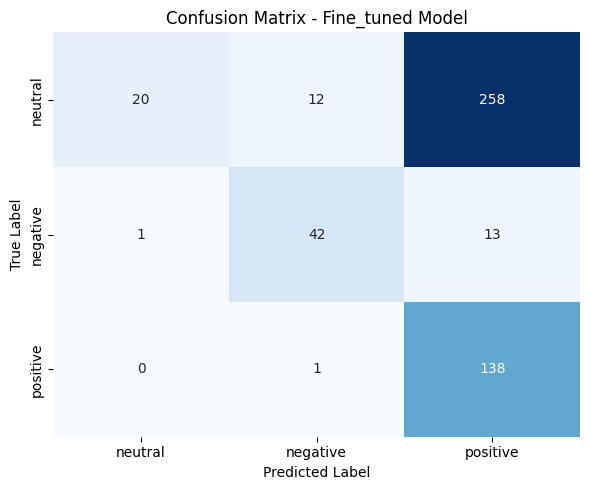

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(filtered_true_tuned, filtered_preds_tuned, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fine_tuned Model")
plt.tight_layout()
plt.show()


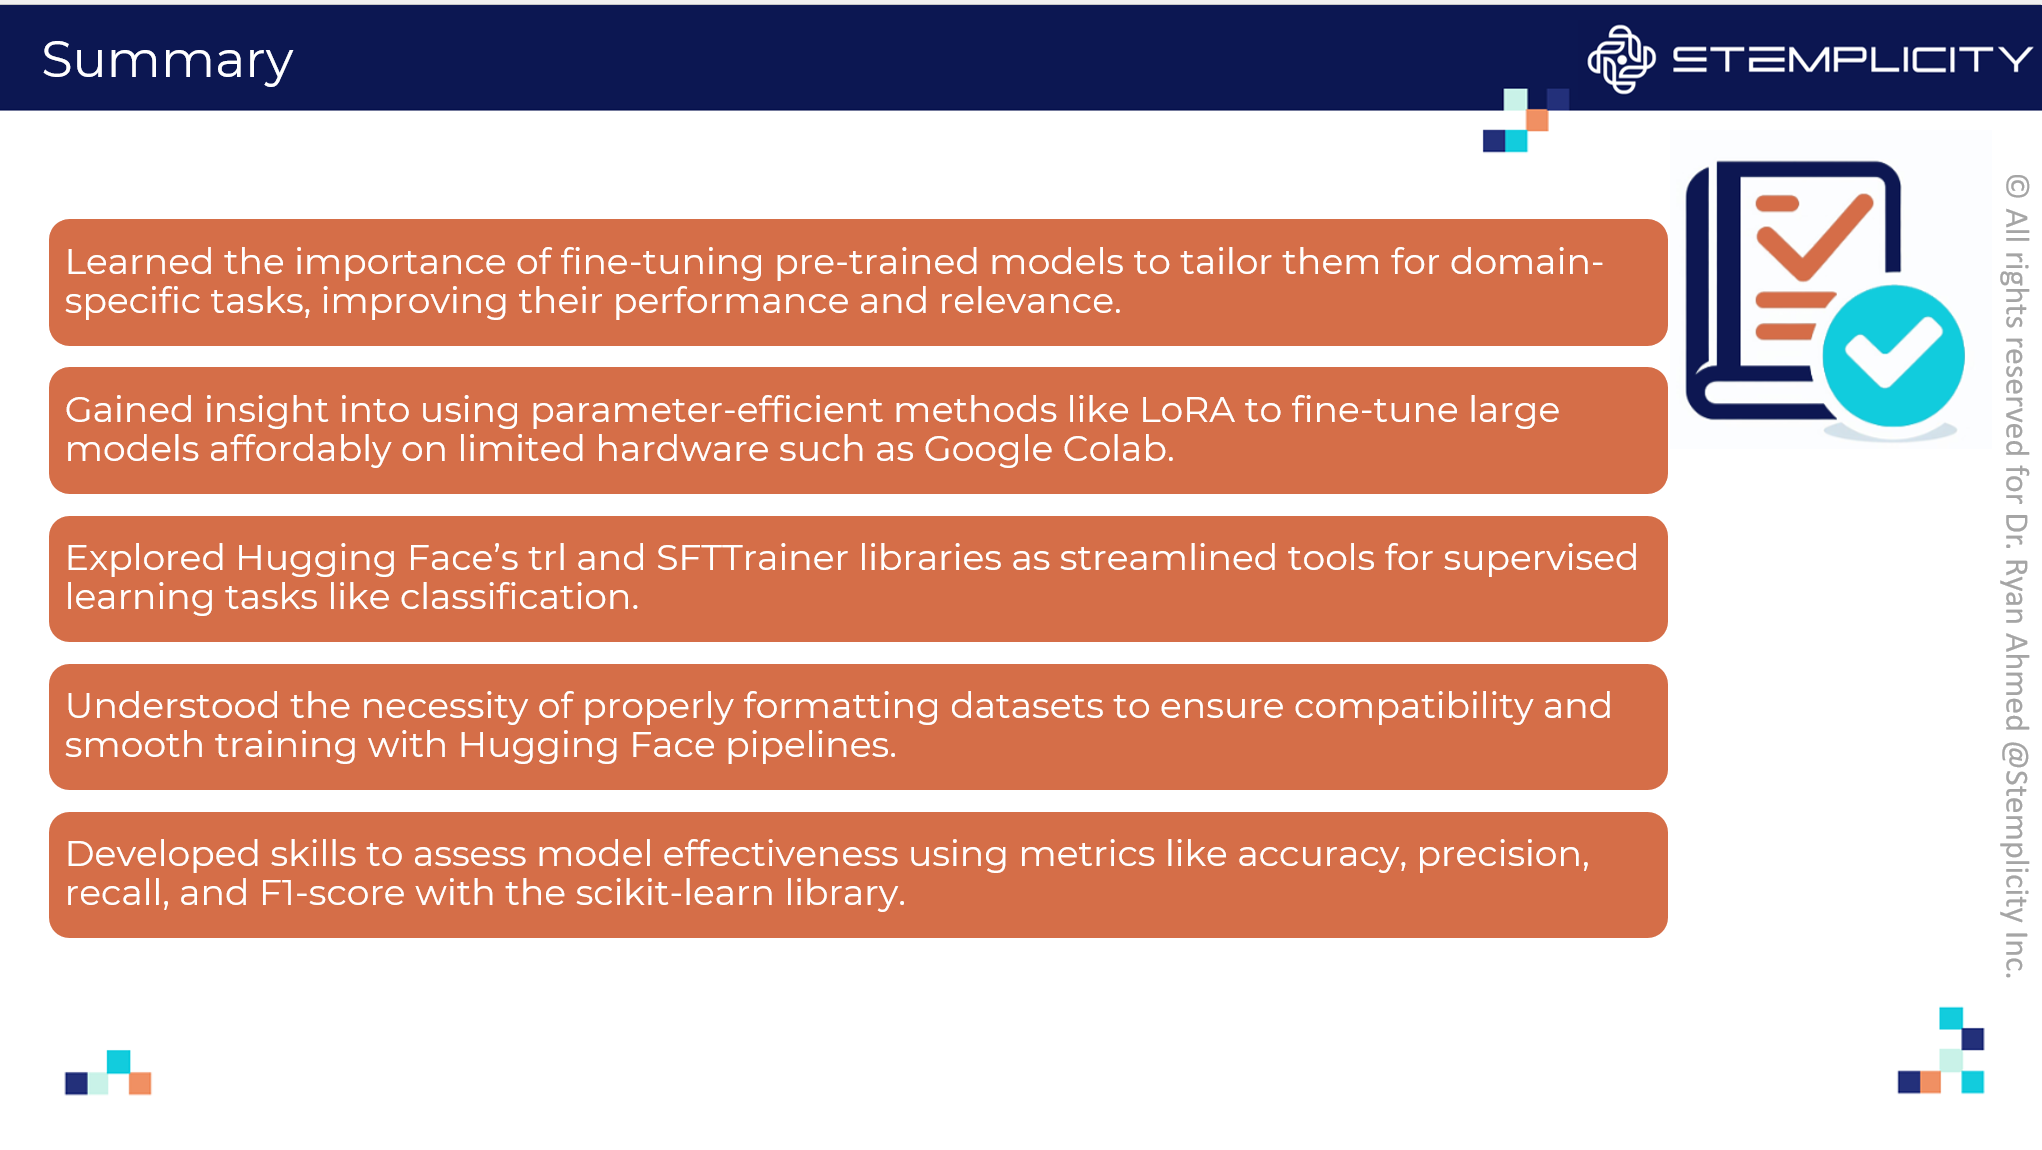

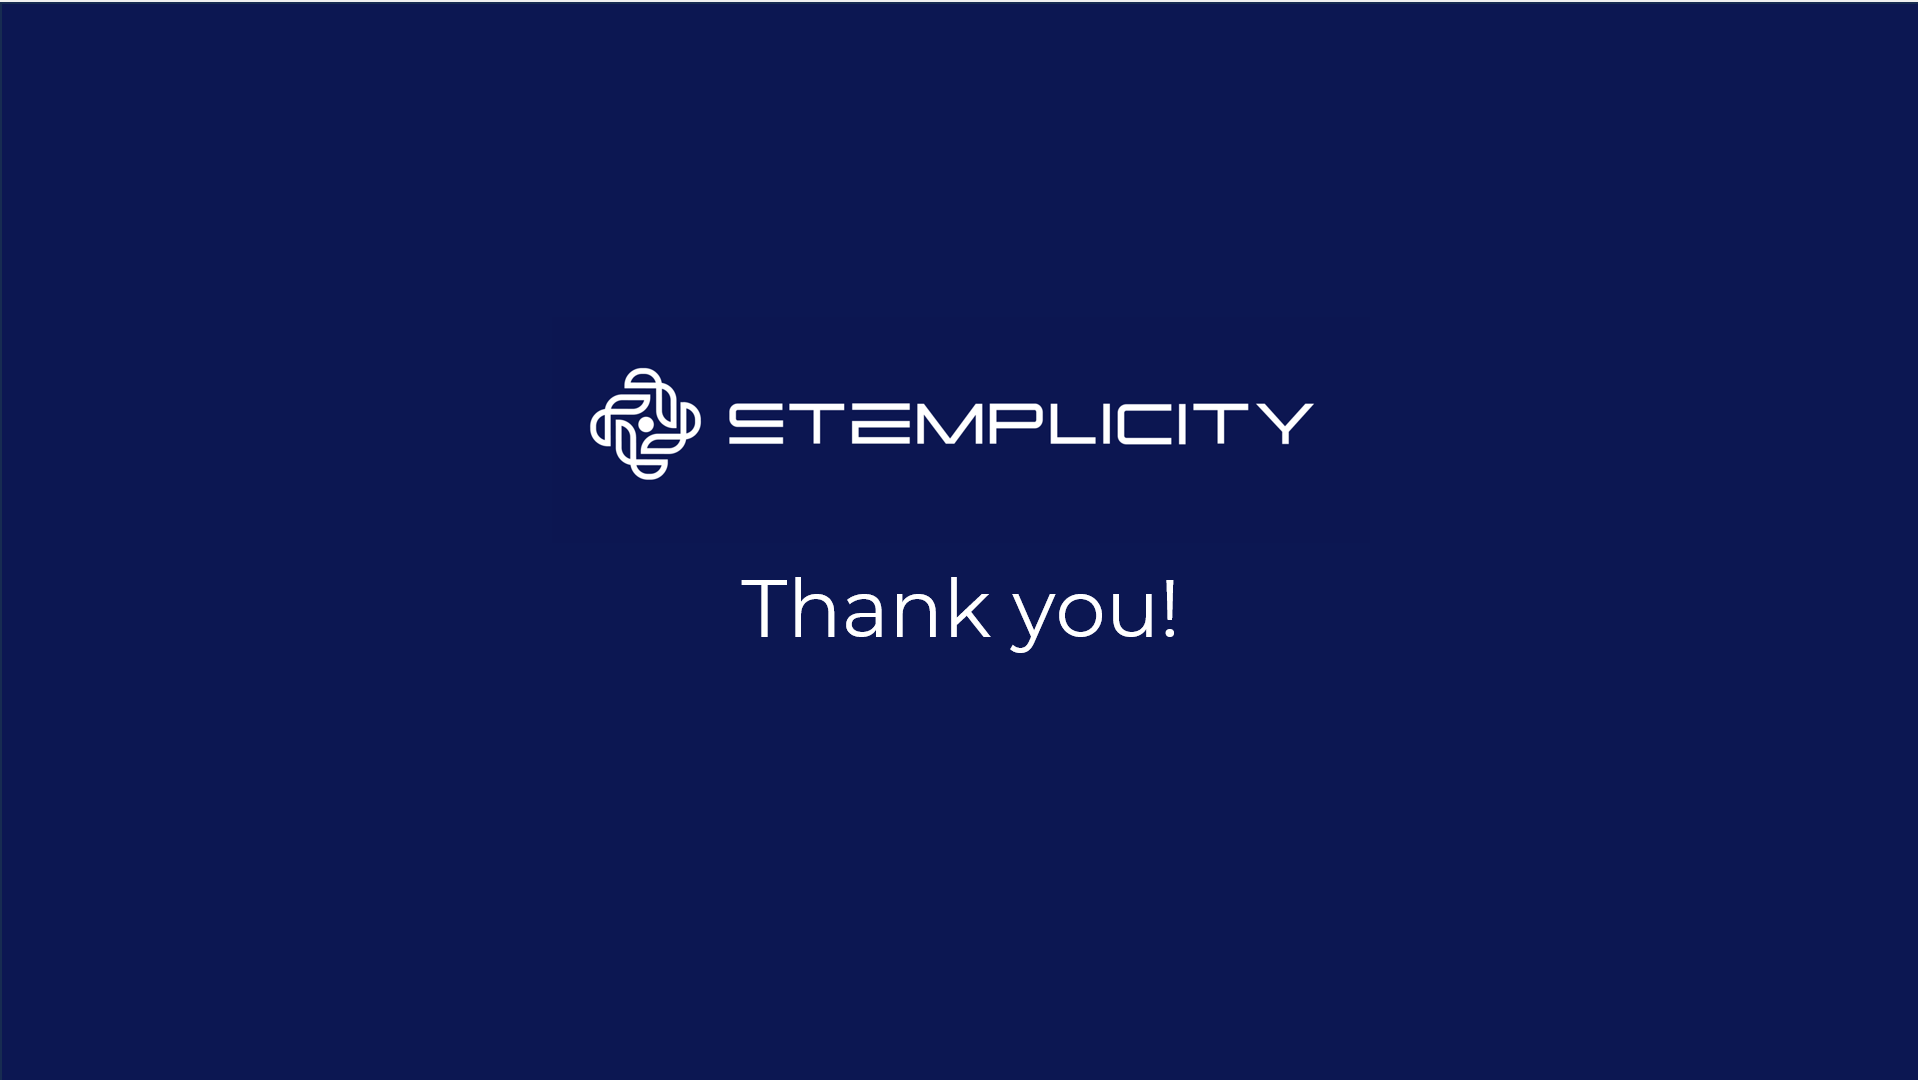